# Utilities (to import !!)

### Network

In [1]:
%load_ext Cython

In [2]:
%%cython

#
#  Network
#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Raw_SBM(object):
    def __init__(self, X):
        self.X = np.array(X, dtype = np.float)
        self.N = len(X)
        self.Q = None
        
    def plot(self):
        a = np.where(self.X > 0)
        plt.scatter(a[0], a[1], marker="X", s=1)
        return self
        
        
        
class HofWig_SBM(Raw_SBM):
    def __init__(self, n, Q, alpha = None, p_epsilon = 0.1, p_lambda = 0.9):
        
        if alpha is None:
            a = np.random.uniform(size=Q)
            alpha = a/a.sum()
        if len(alpha) != Q: raise ValueError("Alpha has not the same length as Q")

        # Defines class
        Z = np.zeros(n, dtype=np.uint)
        i = 0
        for q, n_q in enumerate(np.random.multinomial(n, alpha)):
            for j in range(n_q):
                Z[i] = q
                i += 1

        # Probability matrix of connection between classes
        pi = self._get_pi(Q, p_lambda, p_epsilon)

        # Matrix of connections
        X = np.zeros((n,n))
        for i in range(n):
            q_i = Z[i]
            for j in range(i):
                q_j = Z[j]
                bound = np.random.binomial(1, pi[q_i][q_j])
                X[i][j] = bound
                X[j][i] = bound
        
        super(HofWig_SBM, self).__init__(X)

        self.Z = Z
        self.Q = Q
        
        
    def _get_pi(self, Q, p_lambda, p_epsilon):
        return np.zeros((Q,Q)) + p_epsilon + np.diag([p_lambda - p_epsilon]*Q)
         
        
    def compare(self, Z):
        if self.Z is None:
            raise ValueError("This network does not have a Z variable. SVBM can't compare !")
            
        return pd.DataFrame([list(Z), list(self.Z)]).transpose().groupby([0,1]).size()
    
    
    
class Hub_SBM(HofWig_SBM):
    def _get_pi(self, Q, p_lambda, p_epsilon):
        pi = super(Hub_SBM, self)._get_pi(Q, p_lambda, p_epsilon)
        pi[Q-1] = [p_lambda]*Q
        return pi
        

class CSV_SBM(Raw_SBM):
    def __init__(self, path, header = True):
        raw = np.loadtxt(path, delimiter = ",")
        X = raw[1:,:] if header else raw
        super(CSV_SBM, self).__init__(X)
 





#
#  SVBM
#


from sklearn.cluster import KMeans

from scipy.special import digamma, gammaln
cimport scipy.special.cython_special

#from math import log, exp
from libc.math cimport log, exp

import matplotlib.pyplot as plt


import numpy as np
cimport numpy as np

DTYPE = np.float
ctypedef np.float_t DTYPE_t
        

cdef class SVBM(object):
    
    cdef public net, results
    
    def __init__(self, net):
        self.net = net
        
        self.results = {}
        
        
        
    cdef np.ndarray _init_tau(self, unsigned int Q):
        #Shortcut
        cdef unsigned int N = self.net.N
        cdef np.ndarray X = self.net.X
        
        kmeans = KMeans(n_clusters=Q).fit(X)
        cdef np.ndarray[DTYPE_t, ndim=2] tau = np.zeros([N, Q], dtype=DTYPE)
        
        cdef int i, q
        for i, q in enumerate(kmeans.labels_):
            tau[i][q] = 1
            
        return tau

    
    
    cdef float _lower_bound_aprox(self,\
                                  np.ndarray[DTYPE_t, ndim=1, mode="c"] N,\
                                  np.ndarray[DTYPE_t, ndim=2, mode="c"] eta,\
                                  np.ndarray[DTYPE_t, ndim=2, mode="c"] zeta,\
                                  np.ndarray[DTYPE_t, ndim=2, mode="c"] tau):
        # Shortcut
        cdef int n = tau.shape[0]
        cdef int Q = tau.shape[1]
        
        cdef float s = 0
        cdef int l, q, i
        
        s += gammaln(Q*0.5) - gammaln(sum(N)) - Q*gammaln(0.5)
        for q in range(Q):
            s += gammaln(N[q])

        s += (Q*(Q+1)*0.5)*(gammaln(1) - 2*gammaln(0.5))
        
       
        for l in range(Q):
            for q in range(l+1):
                s += gammaln(eta[q][l]) + gammaln(zeta[q][l]) - gammaln(eta[q][l]*zeta[q][l])

        for i in range(n):
            for q in range(Q):
                s -= 0 if tau[i][q] == 0  else tau[i][q]*log(tau[i][q])

        return s
      
        
        
    def _iter_theta(self, int Q, np.ndarray[DTYPE_t, ndim=2, mode="c"] tau):
        #Shortcut
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] X = self.net.X
        cdef int N = len(tau)
        
        cdef np.ndarray[DTYPE_t, ndim=1, mode="c"] n = np.zeros(Q, dtype=DTYPE)
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] eta = np.zeros([Q,N], dtype=DTYPE)
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] zeta = np.zeros([Q,N], dtype=DTYPE)
        
        cdef int q, i, l, j
        cdef float s_n, s_eta, s_zeta 
        for q in range(Q):                            
            # N
            s_n = 0.5
            for i in range(N):
                s_n += tau[i,q]
            n[q] = s_n

            # Eta, Zeta
            for l in range(Q):
                s_eta, s_zeta = 0.5, 0.5 # Default value
                for j in range(N):
                    for i in range(N):
                        if (q == l and j <= i): break
                        if i == j: continue

                        s_eta += X[i,j]*tau[i,q]*tau[j,l]
                        s_zeta += (1-X[i,j])*tau[i,q]*tau[j,l]

                eta[q,l] = s_eta
                zeta[q,l] = s_zeta 
        
        return n, eta, zeta
    
    
    
    def _iter_tau(self,
                  np.ndarray[DTYPE_t, ndim=1, mode="c"] n,\
                  np.ndarray[DTYPE_t, ndim=2, mode="c"] eta,\
                  np.ndarray[DTYPE_t, ndim=2, mode="c"] zeta,\
                  np.ndarray[DTYPE_t, ndim=2, mode="c"] tau):
        
        #Shortcut
        cdef int Q = len(n)
        cdef int N = self.net.N
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] X = self.net.X
        
        # Computing digamma...
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] dig_sum = digamma(eta + zeta)
        cdef float dig_n_sum = digamma(n.sum())
        zeta, eta, n = digamma(zeta), digamma(eta), digamma(n)
        
        cdef int i, q, j, l
        cdef float delta = 0
        cdef float a
        cdef np.ndarray[DTYPE_t, ndim=1, mode="c"] tau_i
        for i in range(N):
            tau_i = np.zeros(Q)
            for q in range(Q):
                p = exp(n[q]-dig_n_sum)
                for j in range(N):
                    if (i==j): continue
                    for l in range(Q):
                        a = zeta[q,l] - dig_sum[q,l] + X[i,j]*(eta[q,l] - zeta[q,l])
                        #a = digamma(zeta[q,l])\
                        #     - digamma(eta[q,l] + zeta[q,l])\
                        #     + X[i,j]*(digamma(eta[q,l]) - digamma(zeta[q,l]))
                        a *= tau[j,l]
                        p *= exp(a)
                tau_i[q] = p
            tau_i *= 1/sum(tau_i)
            delta += np.linalg.norm(tau_i - tau[i])
            tau[i] = tau_i
        
        return tau, delta
        
    
    
    def run_Q(self, Q):
        if Q in self.results:
            return self.results[Q]
        
        print("Computing for " + str(Q) + " classes...")
        
        #Shortcut
        N, X = self.net.N, self.net.X
         
        # Init
        print("Initialisation via K-means...")
        tau = self._init_tau(Q)
        
        print("Iterating Variational EM...", end="\r")
        for iterr in range(300):
            
            # Esperance
            n, eta, zeta = self._iter_theta(Q, tau)

            # Maximisation
            tau, delta = self._iter_tau(n, eta, zeta, tau)

            # Lower bound
            lower_bound = self._lower_bound_aprox(n, eta, zeta, tau)
            
            # Show
            print("Iteration n°" + str(iterr+1) + " :"\
                  + " Lower bound -> " + str(lower_bound)\
                  + " | Delta -> " + str(delta), end="\r")
            
            # Break condition
            if (299 <= iterr):
                print("\nNo convergence !")
                conv = False
                break
            if (delta < 10E-4):
                print("\nEM has converged")
                conv = True
                break
        
        self.results[Q] = (self._compute_Z(tau), lower_bound, conv)
        return self.results[Q]
    
    
    
    def _compute_Z(self, tau):            
        res = []
        for t  in tau:
            res.append(t.argmax())
        return res
    
    def get_results(self, i = None):
        return self.results if i is None else self.run_Q(i)
    
    
    def run(self, Q_min = 2, Q_max = None):
        Q_max = Q_min if Q_max is None else Q_max
        
        for Q in range(Q_min, Q_max + 1):
            self.run_Q(Q)
            
            
    def plot_lower_bound(self):
        X, Y = [], []
        plt.figure()
        for Q, r in self.get_results().items():
            X.append(Q)
            Y.append(r[1])
        plt.scatter(X, Y)
        
    def plot_matrix(self, q = None):
        X = np.array(self.net.X)
        n = len(X)
        Z = np.array(self.get_results(q)[0]) if q is not None else np.zeros(n)

        plt.figure()
        plt.plot([0,0], [0,200], color="red")
        plt.plot([0,200], [0,0], color="red")

        res = {}
        for q in np.unique(Z):
            a = np.where(Z == q)[0]
            a = dict(zip(a, range(len(res), len(res) + len(a))))
            res.update(a)

            # Plot line
            plt.plot([len(res), len(res)], [0,200], color="red")
            plt.plot([0,200], [len(res), len(res)], color="red")

        person_to_id = res
        del res

        def get_id(person):
            return person_to_id[person]

        a = np.vectorize(get_id)(np.where(X == True))
        plt.scatter(a[0], a[1], marker="X", s=1)

In [3]:
#%%timeit
# (200,4,2) -> 3.14 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# (200,4,2) -> 1.54 s ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 681 ms ± 8.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) -> [][]
# 654 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) -> mode="c"
# 27.9 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each) -> digamma compute
# 21.8 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
#s = SVBM(net)
#s.run(2, 5)

# You can work here

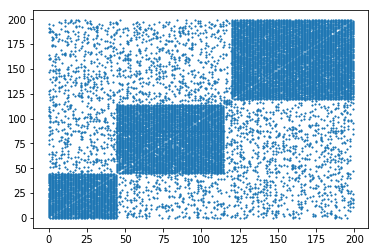

In [4]:
#net_real = CSV_SBM("matrix_known.csv")
net = HofWig_SBM(200,4)
net.plot()

In [5]:
s = SVBM(net)

In [6]:
s.run(Q_min = 2, Q_max = 8)

Computing for 2 classes...
Initialisation via K-means...
Iteration n°1 : Lower bound -> -332644288.0 | Delta -> 3.4416913763379853e-15
EM has converged
Computing for 3 classes...
Initialisation via K-means...
Iteration n°1 : Lower bound -> -95957416.0 | Delta -> 3.3314940839660953e-15
EM has converged
Computing for 4 classes...
Initialisation via K-means...
Iteration n°1 : Lower bound -> -87363848.0 | Delta -> 2.55351295663786e-15
EM has converged
Computing for 5 classes...
Initialisation via K-means...
Iteration n°5 : Lower bound -> -87363856.0 | Delta -> 3.544688431666998e-10
EM has converged
Computing for 6 classes...
Initialisation via K-means...
Iteration n°13 : Lower bound -> -87363864.0 | Delta -> 2.5189284319948775e-14
EM has converged
Computing for 7 classes...
Initialisation via K-means...
Iteration n°33 : Lower bound -> -87362864.0 | Delta -> 0.000645714346319437
EM has converged
Computing for 8 classes...
Initialisation via K-means...
Iteration n°56 : Lower bound -> -873638

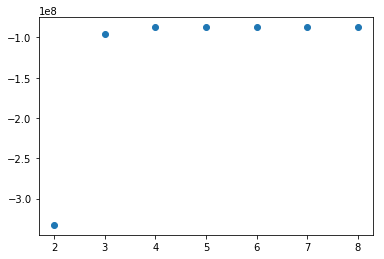

In [7]:
s.plot_lower_bound()

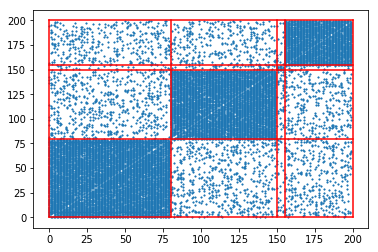

In [8]:
q = 4
s.plot_matrix(q)